In [1]:
# Importing PySpark related libraries
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import concat_ws, regexp_replace, col, lower, to_date, date_format
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, lead, when, coalesce, expr, col
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Importing Dash and Plotly for data visualization
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import plotly.express as px

# Additional PySpark functions and features
from pyspark.sql.functions import avg
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, col

# Importing NLTK for natural language processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Downloading NLTK datasets if needed
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Importing datetime library
from datetime import timedelta, datetime, date
######
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

/tmp/ipykernel_16444/1145620337.py:14: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/tmp/ipykernel_16444/1145620337.py:15: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [2]:
spark = SparkSession.builder.appName('ProjectTweets').getOrCreate()

# DATA PREPARATION

In [3]:
df = spark.read.csv('/user1/ProjectTweets.csv', header=True, inferSchema=True)

In [4]:
df.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



In [5]:
df.show(5, truncate=False)

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0  |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|1  |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2  |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus       |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|3  |1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleCTF    

In [6]:
new_cols = ['ids', 'date', 'flag', 'user', 'text']

for i, column_name in enumerate(new_cols):
    df = df.withColumnRenamed(df.columns[i + 1], column_name)

In [7]:
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

In [8]:
date_column = df.select('date')

In [9]:
df = df.withColumn('date', to_date(df['date'], 'EEE MMM dd HH:mm:ss zzz yyyy'))

In [10]:
df = df.withColumn('date', to_date(col('date'), 'dd/MM/yyyy'))

In [11]:
# Convert text data to lowercase and clean unnecessary characters
df = df.withColumn("text", lower(regexp_replace(col("text"), "[^a-zA-Z0-9\\s]", " ")))

In [12]:
# Remove special symbols, and links from text data
df = df.withColumn("text", regexp_replace(col("text"), r'[@#]\w+|https?://\S+|\W', " "))

In [13]:
df.show(1, truncate=False)

+---+----------+----------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|0  |ids       |date      |flag    |user         |text                                                                                                           |
+---+----------+----------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|1  |1467810672|2009-04-07|NO_QUERY|scotthamilton|is upset that he can t update his facebook by texting it    and might cry as a result  school today also  blah |
+---+----------+----------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
only showing top 1 row



## Sentiment Analysis without Tokenization, Lemmatization and Removing Stopwords

In [14]:
df_for_sentiment_1 = df.select('date', 'text')

In [15]:
# Create Vader SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function for UDF
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Save UDF
sentiment_udf = udf(analyze_sentiment, DoubleType())

In [16]:
# Apply Vader analysis and add the results to a new column
df_for_sentiment_1 = df_for_sentiment_1.withColumn("sentiment_score", sentiment_udf(df_for_sentiment_1["text"]))

In [17]:
# Convert "date" column to 'yyyy-MM-dd' format
df_for_sentiment_1 = df_for_sentiment_1.withColumn("date", F.to_date(df_for_sentiment_1["date"]))

In [18]:
# Ensure you're using the correct column name in the aggregation
daily_sentiment_1 = df_for_sentiment_1.groupBy("date").agg(avg("sentiment_score").alias("avg_sentiment_score")).orderBy("date")

In [19]:
# Create a full date array to include the entire date range
min_date = daily_sentiment_1.selectExpr("min(date) as min_date").first().min_date
max_date = daily_sentiment_1.selectExpr("max(date) as max_date").first().max_date

In [20]:
# Create date array
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
date_range_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

In [21]:
# Fill the gap in date column
daily_sentiment_1 = date_range_df.join(daily_sentiment_1, on=["date"], how="left").orderBy("date").fillna(0, subset=["avg_sentiment_score"])

In [22]:
daily_sentiment_1.printSchema()

root
 |-- date: date (nullable = true)
 |-- avg_sentiment_score: double (nullable = false)



In [23]:
daily_sentiment_1.show()

+----------+-------------------+
|      date|avg_sentiment_score|
+----------+-------------------+
|2009-04-07| 0.1638104692791461|
|2009-04-08|                0.0|
|2009-04-09|                0.0|
|2009-04-10|                0.0|
|2009-04-11|                0.0|
|2009-04-12|                0.0|
|2009-04-13|                0.0|
|2009-04-14|                0.0|
|2009-04-15|                0.0|
|2009-04-16|                0.0|
|2009-04-17|                0.0|
|2009-04-18|0.18738602157202913|
|2009-04-19|0.18894100089100915|
|2009-04-20|0.17782408521710552|
|2009-04-21|0.17327567762269075|
|2009-04-22|                0.0|
|2009-04-23|                0.0|
|2009-04-24|                0.0|
|2009-04-25|                0.0|
|2009-04-26|                0.0|
+----------+-------------------+
only showing top 20 rows



In [24]:
# Use the window function to fill the DataFrame with past and future values
window_spec = Window.orderBy("date")

In [25]:
# Fill missing values with 0
daily_sentiment_1 = daily_sentiment_1.fillna(0, subset=['avg_sentiment_score'])

In [26]:
# 1. Apply Backward Fill interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("backward_fill", lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec))

In [27]:
# 2. Apply Linear Interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("linear_fill", lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec))

In [28]:
# 3. Apply Quadratic Interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("quadratic_fill", coalesce(
    (lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec) + 2 * daily_sentiment_1["avg_sentiment_score"] - lead(daily_sentiment_1["avg_sentiment_score"]).over(window_spec)),
    daily_sentiment_1["avg_sentiment_score"]
))

In [29]:
# 4. Apply Mean of Nearest Neighbors interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("knn_mean", coalesce(
    (daily_sentiment_1["avg_sentiment_score"] + (lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec) + lead(daily_sentiment_1["avg_sentiment_score"]).over(window_spec)) / 2),
    daily_sentiment_1["avg_sentiment_score"]
))

In [30]:
# 5. Apply Mean of Seasonal Counterparts interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("seasonal_mean", coalesce(
    (daily_sentiment_1["avg_sentiment_score"] + (lag(daily_sentiment_1["avg_sentiment_score"], 7).over(window_spec) + lead(daily_sentiment_1["avg_sentiment_score"], -7).over(window_spec)) / 2),
    daily_sentiment_1["avg_sentiment_score"]
))

In [31]:
# Collect the results for visualization
interpolated_data = daily_sentiment_1.select("date", "avg_sentiment_score", "backward_fill", "linear_fill", "quadratic_fill", "knn_mean", "seasonal_mean").collect()

2023-11-10 16:10:30,517 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-10 16:10:30,545 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-10 16:10:30,545 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


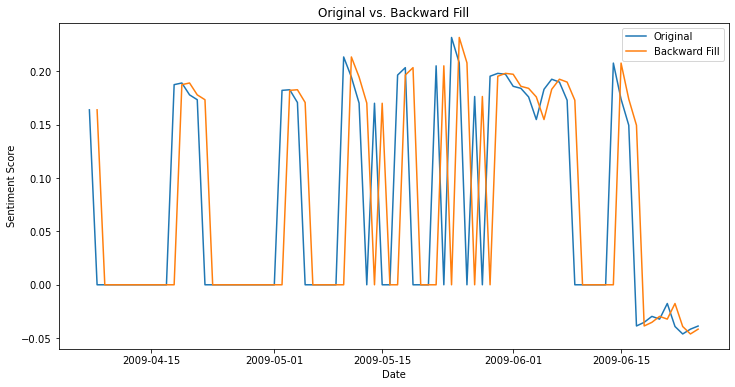

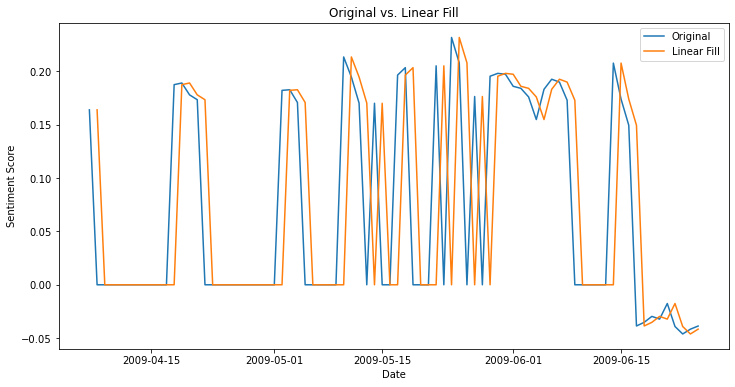

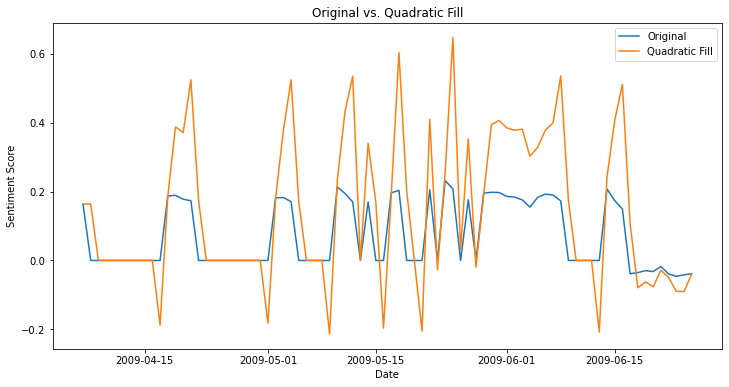

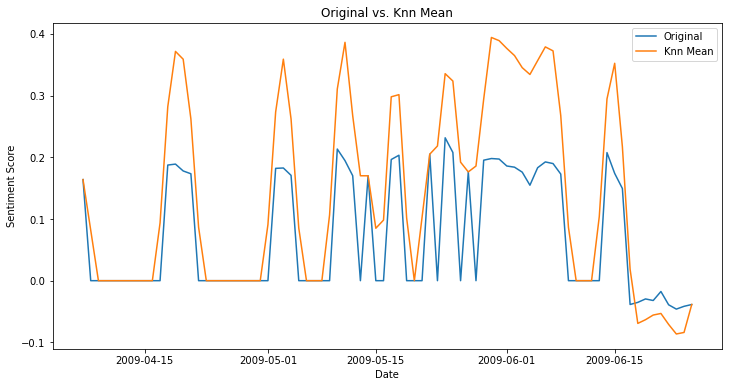

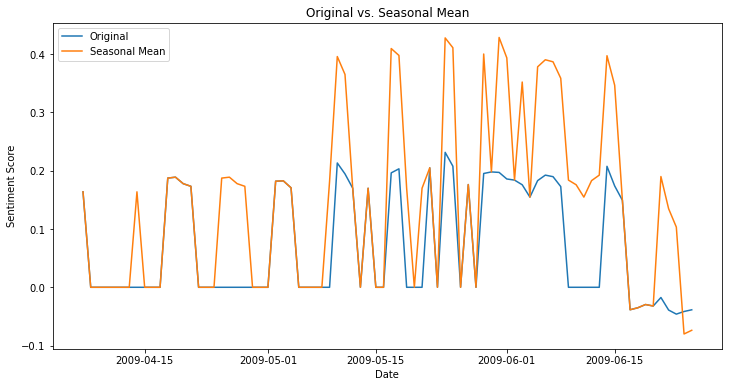

In [32]:
# Extract data for plotting
dates = [row.date for row in interpolated_data]
original_scores = [row.avg_sentiment_score for row in interpolated_data]
interpolation_methods = ["backward_fill", "linear_fill", "quadratic_fill", "knn_mean", "seasonal_mean"]

# Create a loop to plot each interpolation method
for method in interpolation_methods:
    plt.figure(figsize=(12, 6))
    plt.plot(dates, original_scores, label='Original')
    plt.plot(dates, [row[method] for row in interpolated_data], label=method.replace("_", " ").title())  # Use the method name as the label
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.title(f'Original vs. {method.replace("_", " ").title()}')
    plt.legend()
    plt.show()

In [ ]:
# Get the column names
columns = daily_sentiment_1.columns

# Find and print the count of null values in each column
for column in columns:
    null_count = daily_sentiment_1.filter(daily_sentiment_1[column].isNull()).count()
    print(f"Column '{column}' contains {null_count} null values.")

Column 'date' contains 0 null values.
Column 'avg_sentiment_score' contains 0 null values.


2023-11-10 16:15:25,504 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


### Linear Interpolation

In [ ]:
# Define a window specification to order the data by date
window_spec = Window.orderBy("date")

# Calculate the next non-null value using the 'last' function
interpolated_df = daily_sentiment_1.withColumn("next_value", F.last("avg_sentiment_score", True).over(window_spec))

# Calculate the previous non-null value using the 'first' function
interpolated_df = interpolated_df.withColumn("prev_value", F.first("avg_sentiment_score", True).over(window_spec))

# Calculate the linearly interpolated value
interpolated_df = interpolated_df.withColumn(
    "interpolated_value",
    F.when(F.col("avg_sentiment_score") == 0, (F.col("next_value") + F.col("prev_value")) / 2).otherwise(F.col("avg_sentiment_score"))
)

# Drop the 'next_value' and 'prev_value' columns if not needed
interpolated_df = interpolated_df.drop("next_value", "prev_value")

In [ ]:
interpolated_df.printSchema()

In [ ]:
interpolated_df = interpolated_df.select('date', 'interpolated_value')
interpolated_df.show()

In [ ]:
# Get the column names
columns = interpolated_df.columns

# Find and print the count of null values in each column
for column in columns:
    null_count = interpolated_df.filter(interpolated_df[column].isNull()).count()
    print(f"Column '{column}' contains {null_count} null values.")

In [ ]:
# Start DASH
app = dash.Dash(__name__)

# Configure DASH
app.layout = html.Div([
    dcc.Graph(
        id='line-chart',
        figure=px.line(interpolated_df, x='date', y='interpolated_value', title='Daily Average Sentiment Score')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True,  port=8080)

# Time Series Analysis

In [ ]:
# ADF and KPSS test
from statsmodels.tsa.stattools import adfuller, kpss
from pyspark.sql.functions import col
from statsmodels.tsa.seasonal import seasonal_decompose
from pyspark.sql.window import Window

In [ ]:
#windowSpec = Window.orderBy("date")

In [ ]:
# Convert the DF to NumPy array
values = interpolated_df.select("interpolated_value").rdd.flatMap(lambda x: x).collect()

In [ ]:
# ADF(Augmented Dickey Fuller) Test
result_adf = adfuller(values, autolag='AIC')
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
for key, value in result_adf[4].items():
    print('Critial Values:')
    print(f' {key}, {value}')

# KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test
result_kpss = kpss(values, regression='c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
for key, value in result_kpss[3].items():
    print('Critial Values:')
    print(f' {key}, {value}')

The ADF test is commonly used to check if a time series has a unit root, indicating non-stationarity. If the p-value in the ADF test is below 0.05, you reject the null hypothesis.

The KPSS test is commonly used to check if a time series has a unit root, indicating non-stationarity. If the p-value in the ADF test is below 0.05, you conclude that the time series is non-stationary.

In [ ]:
import matplotlib.pyplot as plt

# Take the DF from pyspark
plt.plot(values, color='k')
plt.title('Random White Noise')
plt.show()

In [ ]:
# Detrend the DF
detrended = np.array(values) - np.polyfit(range(len(values)), values, 1)[0] * np.arange(len(values))

# Visualize the detrended DF
plt.plot(detrended)
plt.title('Sentiment Score detrended by subtracting the least squares fit', fontsize=14)
plt.show()

# Seasonality

In [ ]:
import pandas as pd

interpolated_df_pd= interpolated_df.toPandas()

In [ ]:
interpolated_df_pd.head()

In [ ]:
# Preparation for the Algorithm
# ==============================================================================
interpolated_df_pd['date'] = pd.to_datetime(interpolated_df_pd['date'], format='%Y/%m/%d')
interpolated_df_pd = interpolated_df_pd.set_index('date')
interpolated_df_pd = interpolated_df_pd.asfreq('D')
interpolated_df_pd = interpolated_df_pd.sort_index()
interpolated_df_pd.head()

In [ ]:
print(f'Number of rows with missing values: {interpolated_df_pd.isnull().any(axis=1).mean()}')

In [ ]:
# Verify that a temporary index is complete
# ==============================================================================
(interpolated_df_pd.index == pd.date_range(start=interpolated_df_pd.index.min(),
end=interpolated_df_pd.index.max(),
freq=interpolated_df_pd.index.freq)).all()

## AutoRegressive

In [ ]:
# Split data into train-test
# ==============================================================================

# Define the number of steps for test data
steps = 20

# Split the data into training and test sets
data_train = interpolated_df_pd[:-steps]
data_test = interpolated_df_pd[-steps:]

In [ ]:
# Print information about the split
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})")
print(f"Test dates : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)}")

# Create a plot to visualize the train and test data
fig, ax = plt.subplots(figsize=(9, 4))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
import statsmodels.api as sm

# Define your lag variables
# ==============================================================================
data_train['lag1'] = data_train['interpolated_value'].shift(1)
data_train['lag2'] = data_train['interpolated_value'].shift(2)

# Drop missing values
data_train = data_train.dropna()

In [ ]:
# Create and train AR model
# ==============================================================================
X = data_train[['lag1', 'lag2']]
X = sm.add_constant(X)  # Add a constant for the intercept
y = data_train['interpolated_value']

model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

In [ ]:
data_test.head()

In [ ]:
# Initialize lag values
lag1 = data_train['lag1'].iloc[-1]  
lag2 = data_train['lag2'].iloc[-1]  


# Predict 'steps' time periods into the future
forecasted_values = []

for _ in range(steps):
    # Calculate the prediction
    y_pred = model.predict([1, lag1, lag2])
    forecasted_values.append(y_pred[0])  # Access the first element directly

    # Update lag values for the next prediction
    lag2 = lag1
    lag1 = y_pred[0]  # Access the first element directly

In [ ]:
# Create a DataFrame for the predictions with date index
prediction_dates = data_test.index[-steps:]
predictions = pd.DataFrame({'Predicted': forecasted_values}, index=prediction_dates)

In [ ]:
# Print the first 5 rows of the predictions DataFrame
predictions.head()

In [ ]:
data_train.head()

In [ ]:
data_test.head()

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the test error (MSE)
error_mse = mean_squared_error(
    y_true=data_test['interpolated_value'],
    y_pred=predictions['Predicted']
)

# Print the test error
print(f"Test error (MSE): {error_mse}")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [1, 500],
    'max_depth': [1, 2, 3, 4 ,5]
}

# Create the RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# Create Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Initialize variables to store the best hyperparameters and MSE
best_params = None
best_mse = float('inf')

# Perform LOOCV to search for the best hyperparameters
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test data
    forecasted_values = best_model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, forecasted_values)

    if mse < best_mse:
        best_mse = mse

# Print the results
print("Best Hyperparameters:")
print("n_estimators:", best_params['n_estimators'])
print("max_depth:", best_params['max_depth'])
print(f"Best MSE: {best_mse}")

In [ ]:
data_test.head()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define the hyperparameters
n_estimators = 500
max_depth = 3

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Create and train a RandomForestRegressor with the best hyperparameters
regressor = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
regressor.fit(X, y)

In [ ]:
# Predictions on the test set
forecasted_values = regressor.predict(X_test)

In [ ]:
print(forecasted_values)

In [ ]:
# Create an index for the forecasted values
forecasted_index = data_test.index[:len(forecasted_values)]

In [ ]:
print(forecasted_index)

In [ ]:
data_train.head()

In [ ]:
data_test.head()

In [ ]:
data_test.tail()

In [ ]:
# Tahmin değerleri ve indeksini bir DataFrame'e dönüştürme
forecasted_data = pd.DataFrame({'Predicted': forecasted_values}, index=forecasted_index)

# Sonuçları görüntüleme
forecasted_data.head()

In [ ]:
forecasted_data.tail()

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
forecasted_data['Predicted'].plot(ax=ax, label='predicted')
ax.legend()

plt.show()

In [ ]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, forecasted_values)
print(f"Mean Squared Error: {mse}")

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model
order = (2, 0, 0)  # Non-seasonal order
seasonal_order = (1, 0, 1, 7)  # Seasonal order (p, d, q, S)

model_sarima = SARIMAX(data_train['interpolated_value'], order=order, seasonal_order=seasonal_order)
results_sarima = model_sarima.fit()

# Make predictions on the test set
forecasted_values_sarima = results_sarima.predict(start=len(data_train), end=len(data_train) + len(data_test) - 1, typ='levels')

# Create an index for the forecasted values
forecasted_index_sarima = data_test.index[:len(forecasted_values_sarima)]

# Plot
fig, ax = plt.subplots(figsize=(9, 4))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
forecasted_values_sarima.plot(ax=ax, label='SARIMA predictions', color='green')
ax.legend()
plt.show()

# Calculate the test error (MSE)
error_mse_sarima = mean_squared_error(
    y_true=data_test['interpolated_value'],
    y_pred=forecasted_values_sarima
)

# Print the test error for SARIMA
print(f"SARIMA Test error (MSE): {error_mse_sarima}")


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create lag variables
data_train['lag1'] = data_train['interpolated_value'].shift(1)
data_train['lag2'] = data_train['interpolated_value'].shift(2)
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_train['interpolated_value'], lags=25, ax=ax[0])
plot_pacf(data_train['interpolated_value'], lags=25, ax=ax[1])
plt.show()

# Lemmatization, Tokenization, StopWordsRemover

In [ ]:
# Lemmatization using NLTK
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

lemmatize_udf = udf(lemmatize_text, StringType())
df = df.withColumn("text", lemmatize_udf("text"))

In [ ]:
# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="filtered_words")
df = tokenizer.transform(df)

In [ ]:
# Use StopWordsRemover on the "filtered_words" column in your example DataFrame
remover = StopWordsRemover(inputCol="filtered_words", outputCol="filtered_words_without_stopwords")
df = remover.transform(df)

# You can update the column name as per your needs
df = df.withColumnRenamed("filtered_words_without_stopwords", "filtered_words_final")

# Preparing the Dataset for the Databases

In [ ]:
# Just pick the necessary columns
df = df.select('0', 'ids', 'date', 'flag', 'user', 'filtered_words_final')

# Rename the "0" column to "index"
df = df.withColumnRenamed("0", "tweet_index")

# Show the result
#df.show(truncate=False)

In [ ]:
df.dropna()

In [ ]:
# Count the total number of values in the dataframe
#total_count = df.count()

# Show the total count
#print("Total count of values in the dataframe", total_count)

# MySQL

In [ ]:
import pymysql

# Connect to the database
connection = pymysql.connect(
    host="localhost",
    user="root",
    password="password",
    database="ProjectTweets",
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor
)

In [ ]:
# # Create a cursor
cursor = connection.cursor()

# # Create a table
# create_table_sql = """
# CREATE TABLE Tweets (
#     tweet_index INT AUTO_INCREMENT PRIMARY KEY,
#     ids BIGINT,
#     date DATE,
#     flag VARCHAR(55),
#     user VARCHAR(255),
#     filtered_words_final TEXT
# );
# """

In [ ]:
# Create a table
cursor.execute(create_table_sql)

# Save changes
connection.commit()

In [ ]:
# Combine the column named 'filtered_words_final' into a comma-separated column of text.
df = df.withColumn('concatenated_words', concat_ws(",", df['filtered_words_final']))
df.printSchema()

In [ ]:
df = df.select('tweet_index', 'ids', 'date', 'flag', 'user', 'concatenated_words')
df.show(1, truncate=False)

In [ ]:
df.printSchema()

In [ ]:
mysql_url = "jdbc:mysql://localhost:3306/ProjectTweets"
mysql_properties = {
    "user": "root",
    "password": "password",
}


In [ ]:
# df.write.jdbc(url=mysql_url, table="Tweets", mode="overwrite", properties=mysql_properties)

In [ ]:
# # Execute the ALTER TABLE query
# alter_table_sql = "ALTER TABLE Tweets ADD COLUMN YCSB_KEY VARCHAR(255);"
# cursor.execute(alter_table_sql)

In [ ]:
connection.commit()

In [ ]:
df_from_mysql = spark.read.jdbc(url=mysql_url, table="Tweets", properties=mysql_properties)

### Showing results from MySQL

In [ ]:
# Checking the database after insertin the dataframe
df_from_mysql.show()

In [ ]:
# # Create a cursor
# cursor = connection.cursor()

# # Create a table
# create_table_sql = """
# CREATE TABLE YCSB_TEST (
#     tweet_index INT AUTO_INCREMENT PRIMARY KEY,
#     ids BIGINT,
#     date DATE,
#     flag VARCHAR(55),
#     user VARCHAR(255),
#     filtered_words_final TEXT,
#     YCSB_KEY VARCHAR(255)
# );
# """



In [ ]:
#Create a table
cursor.execute(create_table_sql)

#Save changes
connection.commit()

In [ ]:
import subprocess

command = "/home/hduser/ycsb-0.17.0/bin/ycsb.sh load jdbc -P /home/hduser/ycsb-0.17.0/jdbc-binding/conf/db.properties -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.connection_properties=\"user=root&password=password&useSSL=false\" -p jdbc.url=jdbc:mysql://localhost:3306/ProjectTweets -p table=YCSB_TEST"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

if process.returncode == 0:
    print("YCSB operation completed successfully.")
    print("Output:")
    print(stdout.decode('utf-8'))
else:
    print("YCSB operation failed. Error message:")
    print(stderr.decode('utf-8'))


### Due to unidentified Issue YCSB did not work. I decided to use cProfile.

In [ ]:
# Örnek bir sorgu
query = "SELECT * FROM Tweets WHERE concatenated_words"

In [ ]:
import cProfile

def perform_query():
    cursor = connection.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    cursor.close()

if __name__ == '__main__':
    cProfile.run("perform_query()", sort="cumulative")

    Total calls: 1,131,181
    Total time: 3.526 seconds

Top time-consuming functions:

    {built-in method builtins.exec}: 3.526 seconds
    <string>:1(<module>): 3.526 seconds
    3302925674.py:3(perform_query): 3.524 seconds
    cursors.py:133(execute): 3.524 seconds
    cursors.py:319(_query): 3.524 seconds

# Hive

In [ ]:
df.createOrReplaceTempView("temp_table")

In [ ]:
spark.sql("CREATE DATABASE IF NOT EXISTS ProjectTweets")

In [ ]:
create_table_sql = """
CREATE TABLE IF NOT EXISTS ProjectTweets.Tweets (
    tweet_index INT,
    ids BIGINT,
    date DATE,
    flag STRING,
    user STRING,
    concatenated_words STRING
)
STORED AS PARQUET
"""
spark.sql(create_table_sql)

In [ ]:
hive_insert_data_sql = """
INSERT INTO ProjectTweets SELECT * FROM temp_table
"""

In [ ]:
spark.sql(hive_insert_data_sql)

### Showing results from Hive

In [ ]:
# Query
result = spark.sql("SELECT * FROM ProjectTweets")

# Show Result
#result.show()

In [ ]:
import subprocess

command = "/home/hduser/ycsb-0.17.0/bin/ycsb.sh load jdbc -P /home/hduser/ycsb-0.17.0/jdbc-binding/conf/db.properties -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.connection_properties=\"user=root&password=password\" -p jdbc.url=jdbc:hive2://hive_server:10000/ProjectTweets"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

if process.returncode == 0:
    print("YCSB operation completed successfully.")
    print("Output:")
    print(stdout.decode('utf-8'))
else:
    print("YCSB operation failed. Error message:")
    print(stderr.decode('utf-8'))

In [ ]:
import pstats

In [ ]:
# my_hive_script.py
def hive_query():
    query
    pass

if __name__ == "__main__":
    cProfile.run("hive_query()", sort="cumulative")
    
    # Show the results with pstat
    p = pstats.Stats()
    p.print_stats()

# SENTIMENT ANALYSIS AFTER TOKENIZATION, LEMMATIZATION AND STOPWORDS REMOVAL

In [ ]:
df_for_sentiment_2 = df.select('date', 'concatenated_words')

In [ ]:
# Create Vader SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function for the UDF
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Save UDF
sentiment_udf = udf(analyze_sentiment, DoubleType())

In [ ]:
# Apply Vader analysis and add the results to a new column
df_for_sentiment_2 = df_for_sentiment_2.withColumn("sentiment_score", sentiment_udf(df_for_sentiment_2["concatenated_words"]))

df_for_sentiment_2.show()

In [ ]:
# Convert "date" column to 'yyyy-MM-dd' format
df_for_sentiment_2 = df_for_sentiment_2.withColumn("date", F.to_date(df_for_sentiment_2["date"]))

# Create a data frame for date and average sentiment scores
daily_sentiment_2 = df_for_sentiment_2.groupBy("date").agg(avg("sentiment_score").alias("avg_sentiment_score")).orderBy("date")

In [ ]:
# Create a full date array to include the entire date range
min_date = daily_sentiment_2.selectExpr("min(date) as min_date").first().min_date
max_date = daily_sentiment_2.selectExpr("max(date) as max_date").first().max_date

In [ ]:
# Create the date array
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
date_range_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

In [ ]:
# Fill in missing dates
daily_sentiment_2 = date_range_df.join(daily_sentiment_2, on=["date"], how="left").orderBy("date").fillna(0, subset=["avg_sentiment_score"])

In [ ]:
daily_sentiment_2.show()

In [ ]:
# Start the Dash application
app = dash.Dash(__name__)

In [ ]:
# Create the layout of the application
app.layout = html.Div([
    dcc.Graph(
        id='sentiment-line-chart',
        figure=px.line(daily_sentiment_2, x='date', y='avg_sentiment_score', title='Daily Average Sentiment Score')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True, port=8880)

## This is why I chose the dataframe without lemmatization, tokenization, and stop word removal.
- Because there is not enough sentiment score it is almost 0.
- In this case removing special symbols and making the text letters smaller helped to keep the meaning of the text.